# ROLLING CROSS VALIDATION

## MODEL SELECTION

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
to_pedix = str.maketrans("3", "₃")

In [3]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

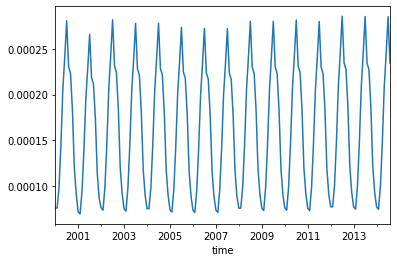

In [4]:
from utils import utils
import matplotlib.pyplot as plt

# TODO Punto di massimo
nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')

train_data, test_data = utils.ts_train_test_split(nh3, .7)

train_data.plot()
plt.show()

In [5]:
def multiple_forecasts(model, ts, times, refit=False):

    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])

    return predictions, errors

In [6]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

def rolling_cross_validation(ts, order, seasonal_order, initial_train_months=36, verbose=False):

    aics = []
    bics = []
    rmses = []
    resid_acfs = []

    train_months = initial_train_months # Mesi di training allo step iniziale
    n = len(ts)

    while train_months < (n-12):
        train_data = ts[0:train_months]
        validation_data = ts[train_months:train_months+24] # Validazione fissa ai 24 mesi successivi

        if verbose:
            print("Traing set: ", train_data .index[0], " to ", train_data.index[-1])
            print("Validation set: ", validation_data.index[0], " to ", validation_data.index[-1])

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aic)
        bics.append(model.bic)

        # Prediction out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)

        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        resid_acf = np.mean(np.abs(acf(model.resid, nlags=24)))
        resid_acfs.append(resid_acf)

        train_months += 12 # Incrementare i mesi di training
    
    return np.mean(aics), np.mean(bics), np.mean(rmses), np.mean(resid_acfs)

In [8]:
# SARIMAX(p,d,q,P,D,Q,s)

import numpy as np

def model_selection(ts, initial_train_months=36, verbose=False):
    
    p_list = [1, 2, 3, 4]
    q_list = [0, 1, 2]
    P_list = [0, 1]
    Q_list = [0, 1]
    s_list = [12]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for s in s_list:
                    
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        aic, bic, rmse, resid_acf = rolling_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s), initial_train_months=initial_train_months)

                        results[model_name] = {
                                'index' : model_idx,
                                'order' : (p,0,q),
                                'seasonal_order' : (P,0,Q,s),
                                'aic' : aic,
                                'bic' : bic,
                                'rmse' : rmse,
                                'acf': resid_acf
                                }

                        idx += 1

    return results

In [9]:
results = model_selection(nh3, initial_train_months=120, verbose=False)

In [10]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
acfs = [v['acf'] for k, v in results.items()]

In [11]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

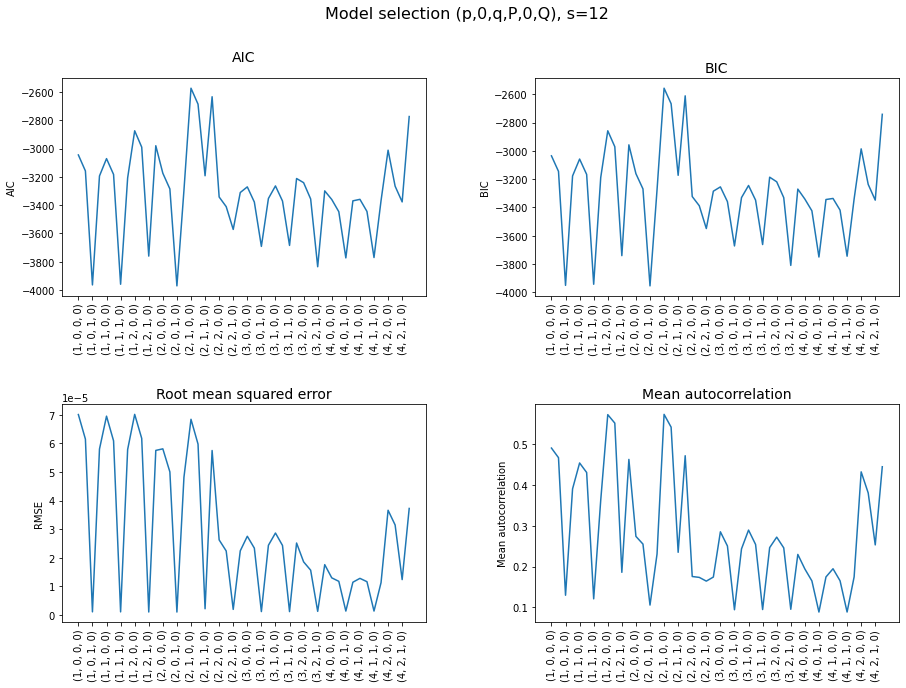

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
indices = np.arange(0, len(results), 2)

fig.suptitle('Model selection (p,0,q,P,0,Q), s=12', fontsize=16)
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)

axs[0,0].plot(aics)
axs[0,0].set_title('AIC', fontsize=14, y=1.05)
axs[0,0].set_xticks(indices)
axs[0,0].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[0,0].set_ylabel('AIC')

axs[0,1].plot(bics)
axs[0,1].set_title('BIC', fontsize=14)
axs[0,1].set_xticks(indices)
axs[0,1].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[0,1].set_ylabel('BIC')

axs[1,0].plot(rmses)
axs[1,0].set_title('Root mean squared error', fontsize=14)
axs[1,0].set_xticks(indices)
axs[1,0].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[1,0].set_ylabel('RMSE')

axs[1,1].plot(acfs)
axs[1,1].set_title('Mean autocorrelation', fontsize=14)
axs[1,1].set_xticks(indices)
axs[1,1].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[1,1].set_ylabel('Mean autocorrelation')

plt.show()

In [13]:
print('min AIC: {}, min BIC {}, min RMSE {}, min ACF'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses), np.argmin(bics)))

min AIC: 14, min BIC 14, min RMSE 14, min ACF


In [14]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'index': 14,
 'order': (2, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3970.595661703049,
 'bic': -3954.9021001005494,
 'rmse': 1.0713304353430892e-06,
 'acf': 0.10567102077368881}

In [15]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'index': 14,
 'order': (2, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3970.595661703049,
 'bic': -3954.9021001005494,
 'rmse': 1.0713304353430892e-06,
 'acf': 0.10567102077368881}

In [16]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'index': 14,
 'order': (2, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3970.595661703049,
 'bic': -3954.9021001005494,
 'rmse': 1.0713304353430892e-06,
 'acf': 0.10567102077368881}

In [17]:
min_acf_model = [v for k,v in results.items() if v['acf'] == np.min(acfs)][0]
min_acf_model

{'index': 38,
 'order': (4, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3772.7489048713223,
 'bic': -3750.777918627824,
 'rmse': 1.4106658706993633e-06,
 'acf': 0.08859593342426406}

In [18]:
# Select models with aic near the minimum found
min_aic = np.min(aics)
candidate_models = [v for k,v in results.items() if v['aic'] < min_aic*0.95 ]

In [19]:
aics = [v['aic'] for v in candidate_models]
bics = [v['bic'] for v in candidate_models]
rmses = [v['rmse'] for v in candidate_models]
acfs = [v['acf'] for v in candidate_models]

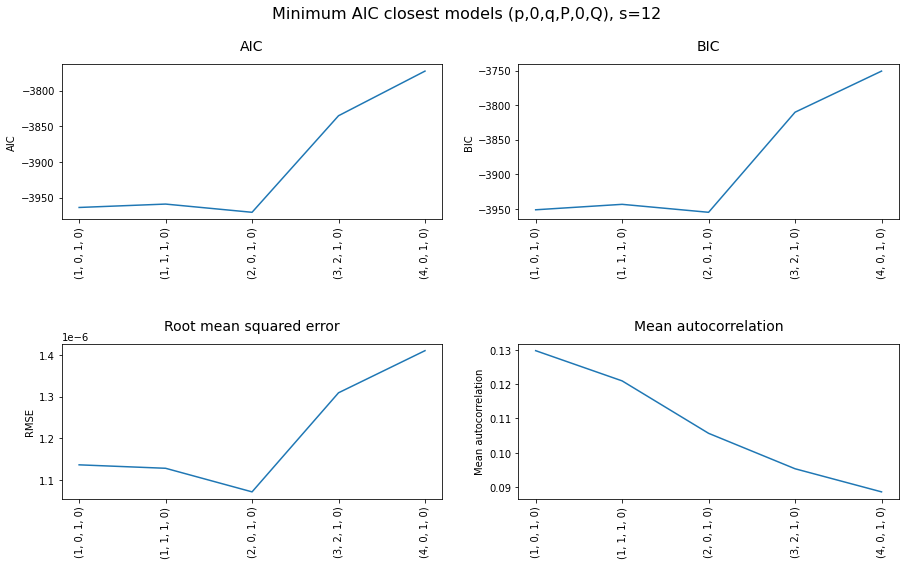

In [20]:
ticks = [tick(v['order'], v['seasonal_order']) for v in candidate_models]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
indices = np.arange(0, len(candidate_models), 1)

fig.subplots_adjust(hspace=0.8)
fig.suptitle('Minimum AIC closest models (p,0,q,P,0,Q), s=12', fontsize=16)

axs[0,0].plot(aics)
axs[0,0].set_title('AIC', fontsize=14, y=1.05)
axs[0,0].set_xticks(indices)
axs[0,0].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[0,0].set_ylabel('AIC')

axs[0,1].plot(bics)
axs[0,1].set_title('BIC', fontsize=14, y=1.05)
axs[0,1].set_xticks(indices)
axs[0,1].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[0,1].set_ylabel('BIC')

axs[1,0].plot(rmses)
axs[1,0].set_title('Root mean squared error', fontsize=14, y=1.05)
axs[1,0].set_xticks(indices)
axs[1,0].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[1,0].set_ylabel('RMSE')

axs[1,1].plot(acfs)
axs[1,1].set_title('Mean autocorrelation', fontsize=14, y=1.05)
axs[1,1].set_xticks(indices)
axs[1,1].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[1,1].set_ylabel('Mean autocorrelation')

plt.show()

## RESIDUAL ANALYSIS

In [21]:
best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()

In [22]:
pd.DataFrame([best_model.params, best_model.pvalues], ['value', 'pvalue'])

,const,ar.L1,ar.L2,ar.S.L12,sigma2
value,0.000163,1.453433,-0.737639,0.999624,2.838353e-12
pvalue,0.224917,0.000000,0.000000,0.000000,9.847158e-01


## Out-of-sample predictions

<AxesSubplot:xlabel='time'>

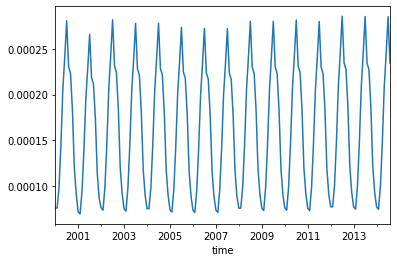

In [23]:
train_data.plot()

In [24]:
best_model = ARIMA(train_data, order=min_rmse_model['order'], seasonal_order=min_rmse_model['seasonal_order']).fit()
pd.DataFrame([best_model.params, best_model.pvalues], ['value', 'pvalue'])

,const,ar.L1,ar.L2,ar.S.L12,sigma2
value,0.000163,1.453433,-0.737639,0.999624,2.838353e-12
pvalue,0.224917,0.000000,0.000000,0.000000,9.847158e-01


In [25]:
predictions, errors = multiple_forecasts(model=best_model, ts=test_data, times=len(test_data), refit=False)

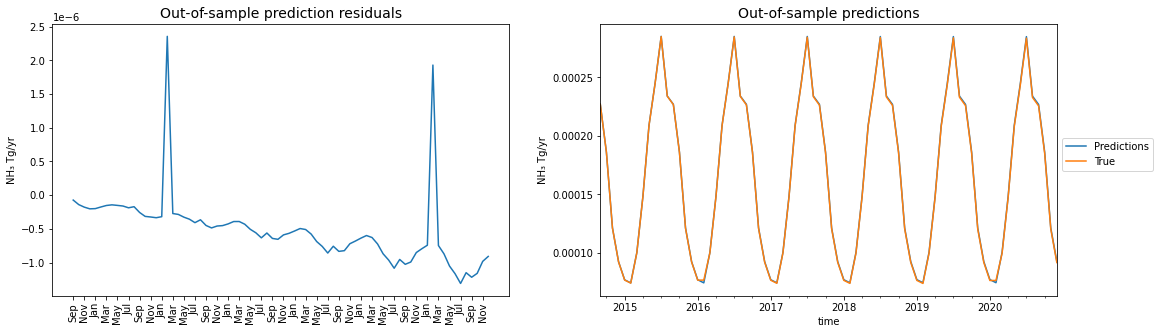

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

indices = np.arange(0, len(test_data), 2)
ticks = [date.strftime('%b') for date in test_data.index]

axs[0].plot(errors)
axs[0].set_title('Out-of-sample prediction residuals', fontsize=14)
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[0].set_ylabel('NH3 Tg/yr'.translate(to_pedix))

pd.Series(predictions, index=test_data.index).plot(ax=axs[1], label='Predictions')
test_data.plot(ax=axs[1], label='True')
axs[1].set_title('Out-of-sample predictions', fontsize=14)
axs[1].set_ylabel('NH3 Tg/yr'.translate(to_pedix))
axs[1].legend(bbox_to_anchor=(1, 0.6))

plt.show()

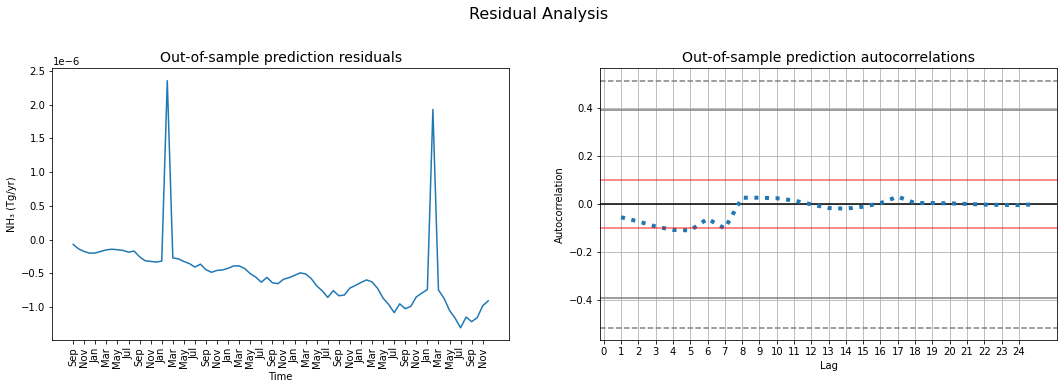

In [27]:
from pandas.plotting import autocorrelation_plot

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual Analysis', fontsize=16, y=1.05)

axs[0].plot(errors)
axs[0].set_title('Out-of-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

indices = np.arange(0, len(test_data), 2)
ticks = [date.strftime('%b') for date in test_data.index]
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

lags = 25
autocorrelation_plot(errors[:lags], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('Out-of-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

indices = np.arange(0, lags, 1)
axs[1].set_xticks(indices)
axs[1].set_xticklabels(indices)

plt.show()

In [28]:
### In-Sample prediction errors

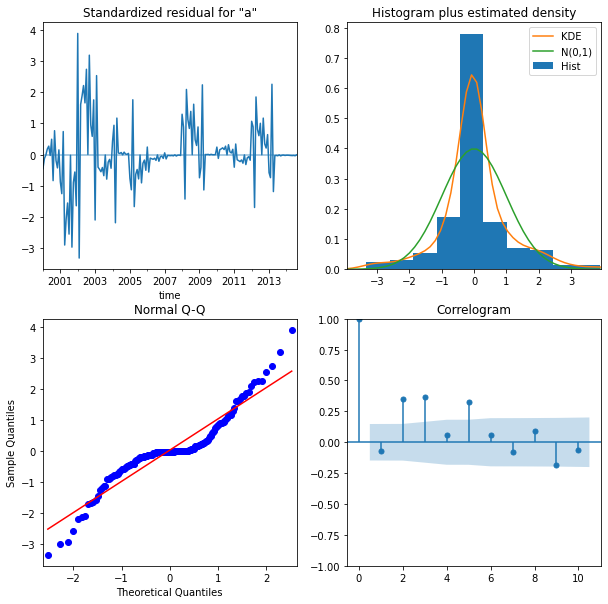

In [29]:
best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

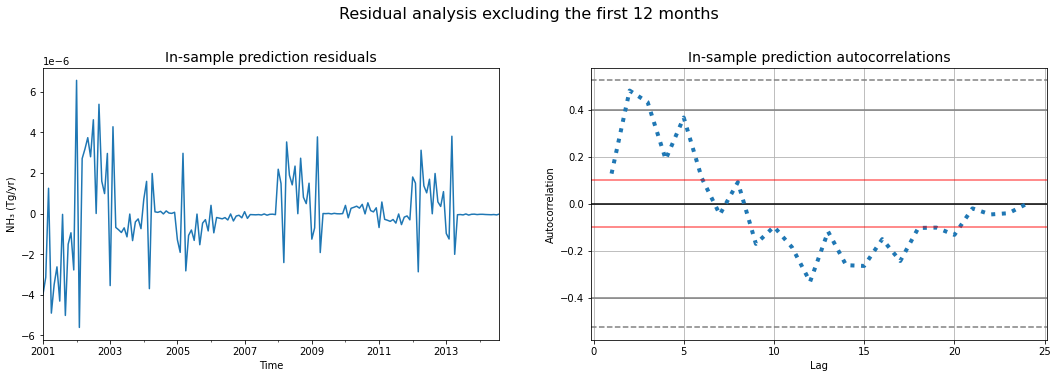

In [30]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual analysis excluding the first 12 months', fontsize=16,  y=1.05)

pd.Series(errors, index=predictions.index).plot(ax=axs[0])
axs[0].set_title('In-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

autocorrelation_plot(errors[:24], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('In-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

plt.show()

### Autocorrelation

Ljung-box test

Checks if residuals are white noise:
* Accept H0 = no autocorrelations between the series and its first `lags` 
* Reject H0 = autocorrelations between the series and its first `lags` 

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

model_df = len(best_model.param_names) # degrees of freedom of the model

lbvalue, pvalue = acorr_ljungbox(errors, lags=12, model_df=model_df)

alpha = 0.05
print(['Correlated' for i in pvalue[pd.notna(pvalue)] if i < alpha])

['Correlated', 'Correlated', 'Correlated', 'Correlated', 'Correlated', 'Correlated', 'Correlated']


### Normality

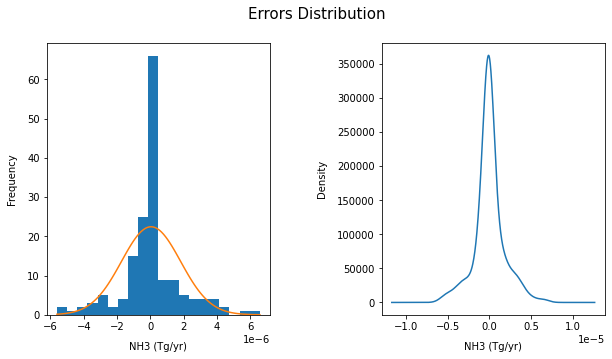

jarque bera test: not normally distributed, pvalue: 5.96835332846078e-09
lilliefors test: not normally distributed, pvalue: 0.0009999999999998899


In [32]:
from utils.plots import plot_distributions
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import lilliefors

plot_distributions(pd.Series(errors), 'Errors Distribution', ['NH3 (Tg/yr)','NH3 (Tg/yr)'])

jb, pvalue, sk, k = jarque_bera(errors)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(errors)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

In [33]:
# Null hypothesis is of no heteroskedasticity

result = best_model.test_heteroskedasticity(method=None)

if result[0, 1] < 0.05: print('Residui eteroschedastici') 
else: print('Residui omoschedastici')
print('pvalue: ', result[0,1])

Residui eteroschedastici
pvalue:  1.59492780800981e-10
